# Faims Analysis

This notebook covers the following things:
- processing
- xirt
- qc

In [83]:
import sys
sys.path.append("../") # go to parent dir
from xifaims import processing as xp
from xifaims import plots as xpl
import yaml
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [84]:
name = "faims_minimal-4PM_DSS_LS_nonunique1pCSM"
outdir = r'..\results\faims_all-4PM_DSS_LS_nonunique1pCSM\\'
outdir = r'..\results\\faims_minimal-4PM_DSS_LS_nonunique1pCSM\\'
metrics_df = pd.read_csv(os.path.join(outdir,r'{}_all_metrics.csv'.format(name)), index_col=0)
predictions_df = pd.read_csv(os.path.join(outdir,r'{}_summary_CV.csv'.format(name)), index_col=0)
summary_df = pd.read_csv(os.path.join(outdir,r'{}_summary_predictions.csv'.format(name)), index_col=0)
clf_df.head()

,cv_split,mse,split,classifier,params,config,infile,run
0,split0_test_score,0.234360,test,SVC,"{'C': 10, 'kernel': 'linear'}",parameters/faims_all.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_all-4PM_DSS_LS_nonunique1pCSM
1,split1_test_score,0.249533,test,SVC,"{'C': 10, 'kernel': 'linear'}",parameters/faims_all.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_all-4PM_DSS_LS_nonunique1pCSM
2,split2_test_score,0.223364,test,SVC,"{'C': 10, 'kernel': 'linear'}",parameters/faims_all.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_all-4PM_DSS_LS_nonunique1pCSM
3,split0_train_score,0.278972,train,SVC,"{'C': 10, 'kernel': 'linear'}",parameters/faims_all.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_all-4PM_DSS_LS_nonunique1pCSM
4,split1_train_score,0.268566,train,SVC,"{'C': 10, 'kernel': 'linear'}",parameters/faims_all.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_all-4PM_DSS_LS_nonunique1pCSM


In [85]:
summary_df.head()

,clf,set,pearson,r2,mse,run
0,FNN,Test,0.57,0.33,73.73,faims_minimal-4PM_DSS_LS_nonunique1pCSM
1,FNN,Train,0.61,0.38,82.84,faims_minimal-4PM_DSS_LS_nonunique1pCSM
2,SVC,Test,0.41,0.17,110.15,faims_minimal-4PM_DSS_LS_nonunique1pCSM
3,SVC,Train,0.49,0.24,96.59,faims_minimal-4PM_DSS_LS_nonunique1pCSM
4,SVR,Test,0.47,0.22,93.58,faims_minimal-4PM_DSS_LS_nonunique1pCSM


In [86]:
metrics_df.head()

,cv_split,mse,split,classifier,params,config,infile,run
0,split0_test_score,0.207283,test,SVC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",parameters/faims_minimal.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_minimal-4PM_DSS_LS_nonunique1pCSM
1,split1_test_score,0.219626,test,SVC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",parameters/faims_minimal.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_minimal-4PM_DSS_LS_nonunique1pCSM
2,split2_test_score,0.229907,test,SVC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",parameters/faims_minimal.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_minimal-4PM_DSS_LS_nonunique1pCSM
3,split0_train_score,0.229907,train,SVC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",parameters/faims_minimal.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_minimal-4PM_DSS_LS_nonunique1pCSM
4,split1_train_score,0.222793,train,SVC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",parameters/faims_minimal.yaml,data/4PM_DSS_LS_nonunique1pCSM.csv,faims_minimal-4PM_DSS_LS_nonunique1pCSM


..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive

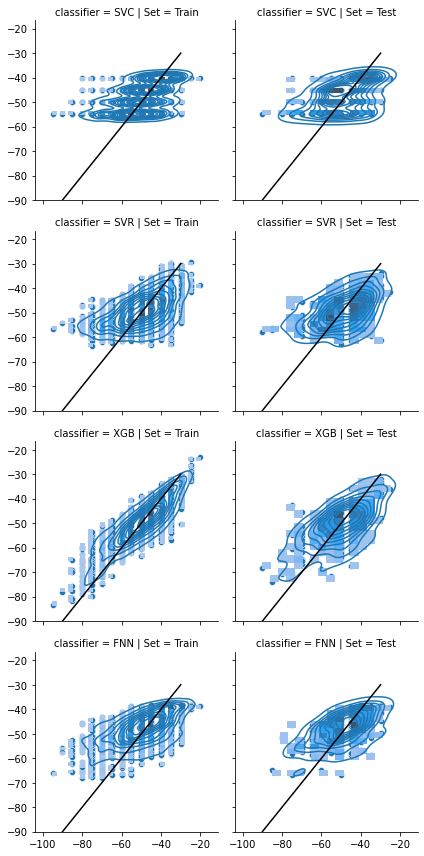

In [87]:
#xpl.train_test_scatter_plot(predictions_df, outdir, show=True)
x = "CV_Train"
y = "CV_Predict"
g = sns.FacetGrid(predictions_df, col="Set", row="classifier", sharex=True, sharey=True)
g = g.map(sns.scatterplot,x, y)
g = g.map(sns.histplot,x, y) #(x=x, y=y, bins=50, pthresh=.1, cmap="mako"))
g = g.map(sns.kdeplot,x, y)#(x=x, y=y, levels=5, color="w", linewidths=1))
g = g.map(xpl.const_line)

..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(cvs, cvs, C='k')
..\xifaims\plots.py:16: MatplotlibDeprecationWarning: Case-insensitive

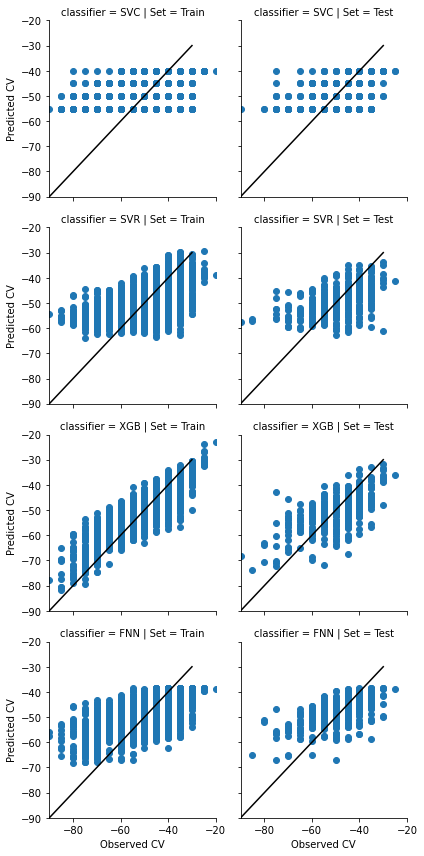

In [89]:
xpl.train_test_scatter_plot(predictions_df, outdir, show=True)

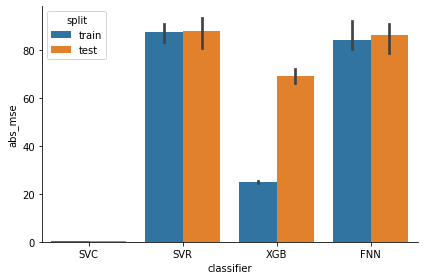

In [88]:
xpl.cv_performance_plot(metrics_df, outdir, show=True)